# PM 다중분류 및 성능 표현
- 파라미터 최적화
- 그리드 탐색 (best model)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from itertools import cycle
from sklearn import metrics
from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neural_network import MLPClassifier

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
%config InlineBackend.figure_format = 'retina'

# 데이터

In [2]:
df_train = pd.read_csv('PM_train_pre.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0


In [3]:
df_test = pd.read_csv('PM_test_pre.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0,0


In [5]:
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

y_train = df_train['label_mcc']
y_test = df_test['label_mcc']

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [6]:
y_train[:2]

array([[1, 0, 0],
       [1, 0, 0]])

# 함수 정의
- 최적 분류기 그리드 탐색
- 성능 리포트

In [7]:
def multiclass_classify(model, clf, features, params=None, score=None, scale=False, OvR=True, prob='P'):
       
    """ 그리드 탐색  
    Args:
        model (str): 모델명
        clf (clssifier object): 분류기
        features (list): 특성
        params (dict): 그리드 탐색 파라미터
        score (str): 그래드 탐색 점수
        OvR (bool): multiclass One-Vs-Rest 지원 여부
        prob (str): 'P' for predict_proba, 'D' for decision_function
        
    Returns:
        최적 분류기 객체
        array: 예측 값
        array: 점수
    """
     
    X_train = df_train[features]
    X_test = df_test[features] 
    
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    grid_search = model_selection.GridSearchCV(estimator=clf, 
                    param_grid=params, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    
    if prob == 'P':   
        y_score = grid_search.predict_proba(X_test)
        if OvR:    
            y_score = [y_score[i][:,[1]] for i in range(len(y_score))]
            y_score = np.concatenate(y_score, axis=1)
    elif prob == 'D':
        y_score = grid_search.decision_function(X_test)
    else:
        y_score = y_pred
    return grid_search.best_estimator_, y_pred, y_score

In [8]:
def multiclass_metrics(model, y_test, y_pred, y_score, print_out=True, plot_out=True):
    
    """ 분류 성능, AUC ROC and Precision-Recall 커브
    
    Args:
        model (str): 모델명
        y_test (series)
        y_pred (series)
        y_score (series)
        print_out (bool): 성능지표 출력 여부
        plot_out (bool): 그림 출력 여부
        
    Returns:
        dataframe: 성능 지표 데이터프레임
        dict: ROC thresholds
        dict: Precision-Recall thresholds
        Plot: AUC ROC
        plot: Precision-Recall
    """
    multiclass_metrics = {
                            'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                            'macro F1' : metrics.f1_score(y_test, y_pred, average='macro'),
                            'micro F1' : metrics.f1_score(y_test, y_pred, average='micro'),
                            'macro Precision' : metrics.precision_score(y_test, y_pred,  average='macro'),
                            'micro Precision' : metrics.precision_score(y_test, y_pred,  average='micro'),
                            'macro Recall' : metrics.recall_score(y_test, y_pred,  average='macro'),
                            'micro Recall' : metrics.recall_score(y_test, y_pred,  average='micro'),
                            'macro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='macro'),
                            'micro ROC AUC' : metrics.roc_auc_score(y_test, y_score, average='micro')
                        }
    
    df_metrics = pd.DataFrame.from_dict(multiclass_metrics, orient='index')
    df_metrics.columns = [model]
    n_classes = y_train.shape[1]
    
    fpr = dict()
    tpr = dict()
    thresh_roc = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        #fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[i][:,0])
        fpr[i], tpr[i], thresh_roc[i] = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    fpr["micro"], tpr["micro"], thresh_roc["micro"] = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

    roc_thresh = {
                    'Threshold' : thresh_roc,
                    'TPR' : tpr,
                    'FPR' : fpr,
                    'AUC' : roc_auc
                 }
    
    df_roc_thresh = pd.DataFrame.from_dict(roc_thresh)
    df_roc_thresh['Model'] = model
    df_roc_thresh['Class'] = df_roc_thresh.index
    
    precision = dict()
    recall = dict()
    thresh_prc = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        #precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[i][:,0])
        precision[i], recall[i], thresh_prc[i] = metrics.precision_recall_curve(y_test[:, i], y_score[:, i])
        average_precision[i] = metrics.average_precision_score(y_test[:, i], y_score[:, i])

    precision["micro"], recall["micro"], thresh_prc["micro"] = metrics.precision_recall_curve(y_test.ravel(), y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test, y_score, average="micro")
    
    prc_thresh = {
                    'Threshold' : thresh_prc,
                    'Precision' : precision,
                    'Recall' : recall,
                    'Avg Precision' : average_precision
                 }

    df_prc_thresh = pd.DataFrame.from_dict(prc_thresh)
    df_prc_thresh['Model'] = model
    df_prc_thresh['Class'] = df_prc_thresh.index    
    
    y_test_orig = lb.inverse_transform(y_test)
    y_pred_orig = lb.inverse_transform(y_pred)
    
    if print_out:
        print('-----------------------------------------------------------')
        print(model, '\n')
        print('Confusion Matrix:')
        print(metrics.confusion_matrix(y_test_orig, y_pred_orig))
        print('\nClassification Report:')
        print(metrics.classification_report(y_test_orig, y_pred_orig))
        print('\nMetrics:')
        print(df_metrics)

    if plot_out:
        
        colors = cycle(['red', 'green', 'blue'])
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False )
        fig.set_size_inches(12,6)
        
        for i, color in zip(range(n_classes), colors):
            ax1.plot(fpr[i], tpr[i], color=color, lw=1, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
        
        ax1.plot(fpr["micro"], tpr["micro"], color='deeppink', label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["micro"]), linestyle=':', linewidth=4)
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right", fontsize='small')
        
        
        for i, color in zip(range(n_classes), colors):
            ax2.plot(recall[i], precision[i], color=color, lw=1, label='Precision-recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
            
        ax2.plot(recall["micro"], precision["micro"], color='deeppink', lw=4, linestyle=':', label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left", fontsize='small')
    
    return df_metrics, df_prc_thresh, df_roc_thresh

# 결정 트리


Best Parameters:
 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
-----------------------------------------------------------
Decision Tree 

Confusion Matrix:
[[12719    39     6]
 [  184    57    31]
 [   14     6    40]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12764
           1       0.56      0.21      0.30       272
           2       0.52      0.67      0.58        60

    accuracy                           0.98     13096
   macro avg       0.69      0.62      0.63     13096
weighted avg       0.97      0.98      0.97    

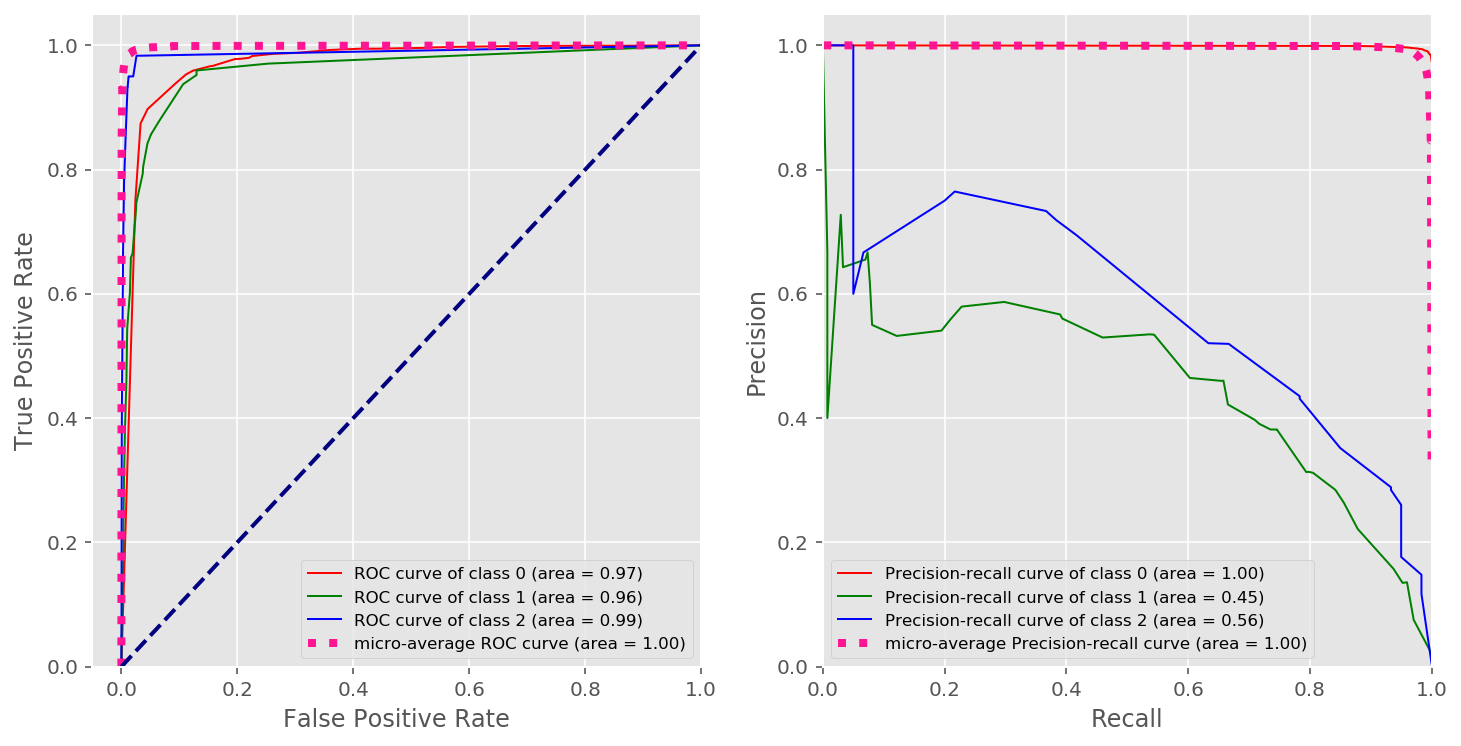

In [26]:
model = 'Decision Tree'
clf_dtrb = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [ 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'

clf_dtrb, y_pred_dtrb, y_score_dtrb = multiclass_classify(model, clf_dtrb, features, 
            params=gs_params, score=gs_score, scale=False, OvR=True, prob='P')
print('\nBest Parameters:\n',clf_dtrb)

metrics_dtrb, prc_dtrb, roc_dtrb = multiclass_metrics(model, y_test, y_pred_dtrb, 
            y_score_dtrb, print_out=True, plot_out=True)

In [14]:
metrics_dtrb

,Decision Tree
Accuracy,0.976787
macro F1,0.626902
micro F1,0.979967
macro Precision,0.689209
micro Precision,0.983168
macro Recall,0.623607
micro Recall,0.976787
macro ROC AUC,0.972954
micro ROC AUC,0.998520


# 랜덤 포레스트


Best Parameters:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
-----------------------------------------------------------
Random Forest 

Confusion Matrix:
[[12759     5     0]
 [  225    40     7]
 [   26     5    29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12764
           1       0.80      0.15      0.25       272
           2       0.81      0.48      0.60        60

    accuracy                        

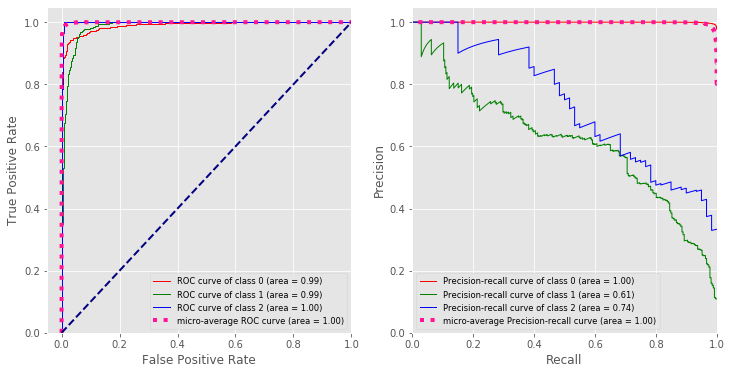

In [15]:
model = 'Random Forest'
clf_rfcb = RandomForestClassifier(n_estimators=50, random_state=123)
gs_params = {'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
gs_score = 'roc_auc'


clf_rfcb, y_pred_rfcb, y_score_rfcb = multiclass_classify(model, clf_rfcb, features, 
                        params=gs_params, score=gs_score, scale=False)
print('\nBest Parameters:\n',clf_rfcb)

metrics_rfcb, prc_rfcb, roc_rfcb = multiclass_metrics(model, y_test, y_pred_rfcb, 
                        y_score_rfcb, print_out=True, plot_out=True)



# MLP

/Users/hwa-kim/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Best Parameters:
 MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=123, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
-----------------------------------------------------------
Neural Net MLP 

Confusion Matrix:
[[12726    35     3]
 [  149   114     9]
 [   14    13    33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     12764
           1       0.70      0.42      0.53       272
           2       0.73      0.55      0.63        60

    accuracy                           0.98     13096
   

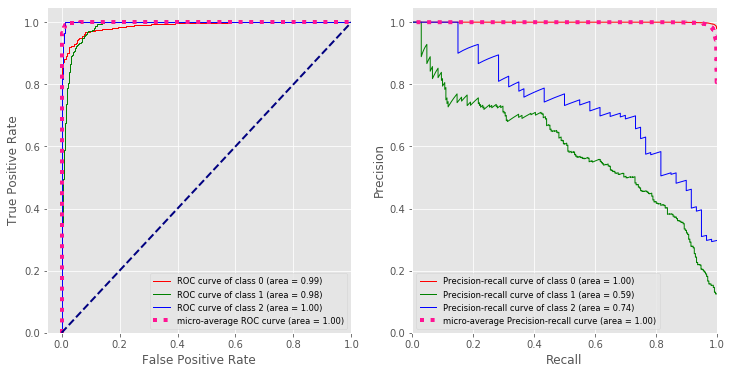

In [16]:
model = 'Neural Net MLP'
clf_nncb = MLPClassifier(solver='adam', random_state=123)
gs_params = {'alpha': [0.001, 0.01], 'hidden_layer_sizes': [(100,), (100,100)]}
gs_score = 'roc_auc'

clf_nncb, y_pred_nncb, y_score_nncb = multiclass_classify(model, clf_nncb, 
            features, params=gs_params, score=gs_score, scale=True, OvR=False)
print('\nBest Parameters:\n',clf_nncb)

metrics_nncb, prc_nncb, roc_nncb = multiclass_metrics(model, y_test, 
            y_pred_nncb, y_score_nncb, print_out=True, plot_out=True)


# 성능 비교

In [20]:
metrics_mc = pd.concat([metrics_dtrb, metrics_rfcb, metrics_nncb],axis=1)
metrics_mc

,Decision Tree,Random Forest,Neural Net MLP
Accuracy,0.976787,0.976405,0.981597
macro F1,0.626902,0.615312,0.722767
micro F1,0.979967,0.982671,0.983674
macro Precision,0.689209,0.865274,0.807683
micro Precision,0.983168,0.989017,0.985068
macro Recall,0.623607,0.542263,0.665472
micro Recall,0.976787,0.976405,0.982285
macro ROC AUC,0.972954,0.991194,0.990212
micro ROC AUC,0.998520,0.999472,0.999436
